In [1]:
# Step 1: Importing Libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from lime.lime_tabular import LimeTabularExplainer


In [2]:
# Step 2: Load and Prepare Dataset
data = pd.read_csv('loan_approval_dataset.csv')
data.columns = data.columns.str.strip()  # Clean column names

# Ensure 'loan_status' is in the correct format
labels = data['loan_status'].astype(str)

# Encode categorical variables using one-hot encoding
data_encoded = pd.get_dummies(data.drop(columns=['loan_status']), drop_first=True)


In [3]:
# Step 3: Train Models
trained_models = []  # Keep track of all details for models we train

def train_model(model, data, labels): 
    X = data
    y = labels.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time

    train_accuracy = pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test) 
    model_details = {
        "name": model["name"],
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_time": train_time,
        "model": pipe
    }
    return model_details

models = [
    {"name": "Naive Bayes", "clf": GaussianNB()},
    {"name": "Logistic Regression", "clf": LogisticRegressionCV()},
    {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
    {"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)},
    {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)},
    {"name": "MLP Classifier", "clf": MLPClassifier(solver='adam', alpha=1e-1, hidden_layer_sizes=(10, 10, 5, 2), max_iter=500, random_state=42)}
]

for model in models:
    model_details = train_model(model, data_encoded, labels) 
    trained_models.append(model_details)


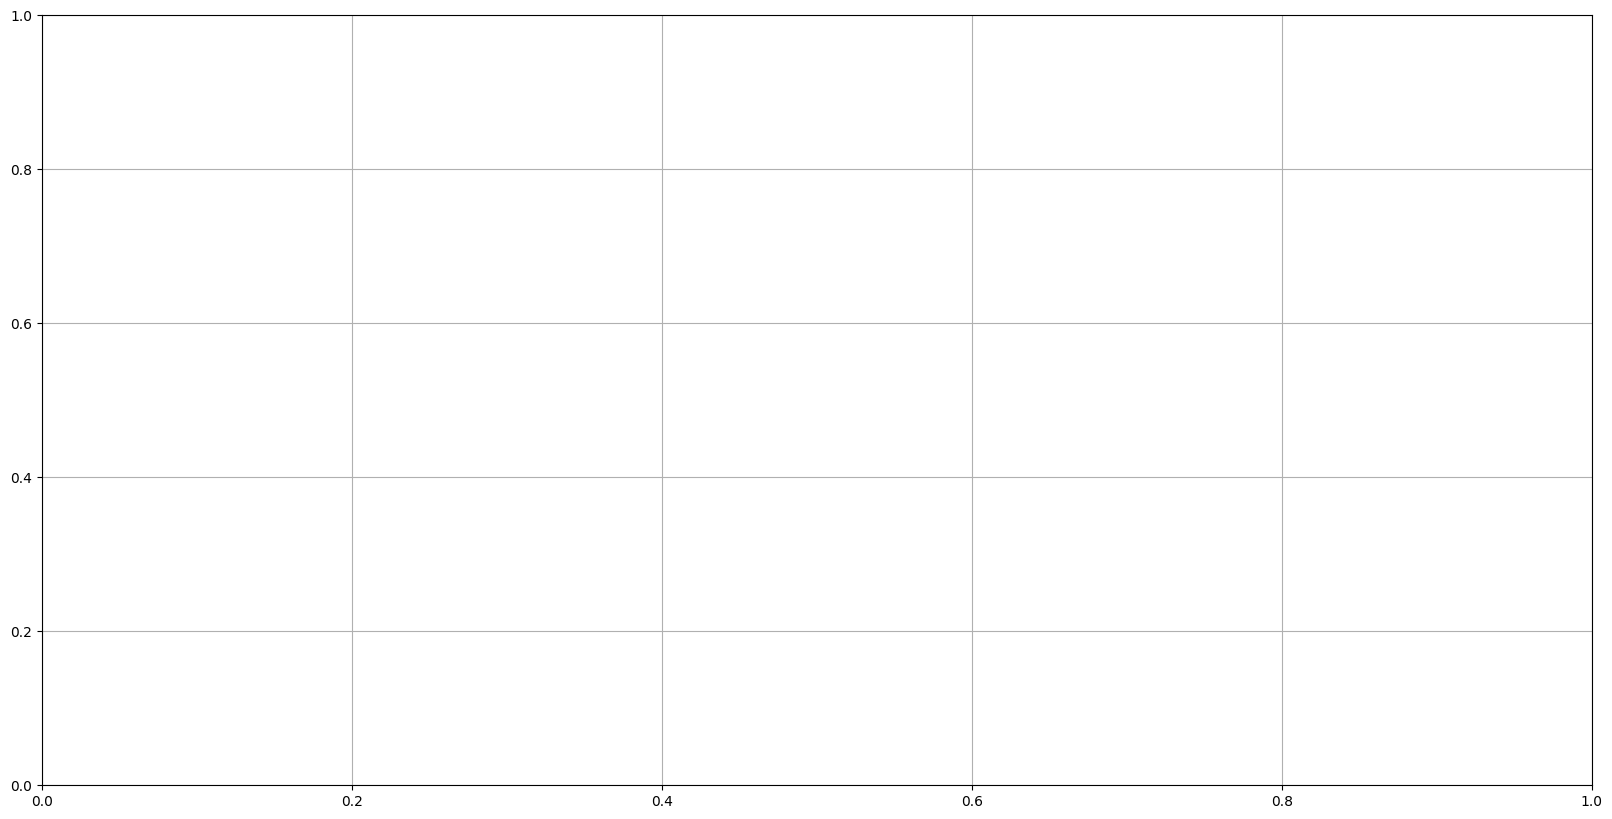

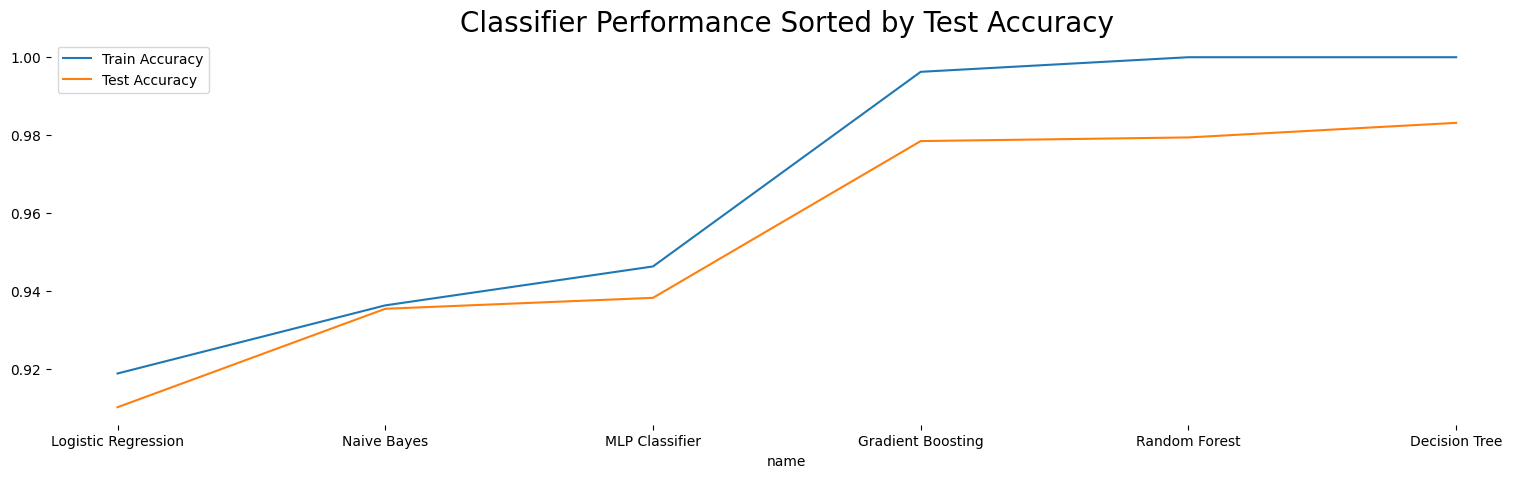

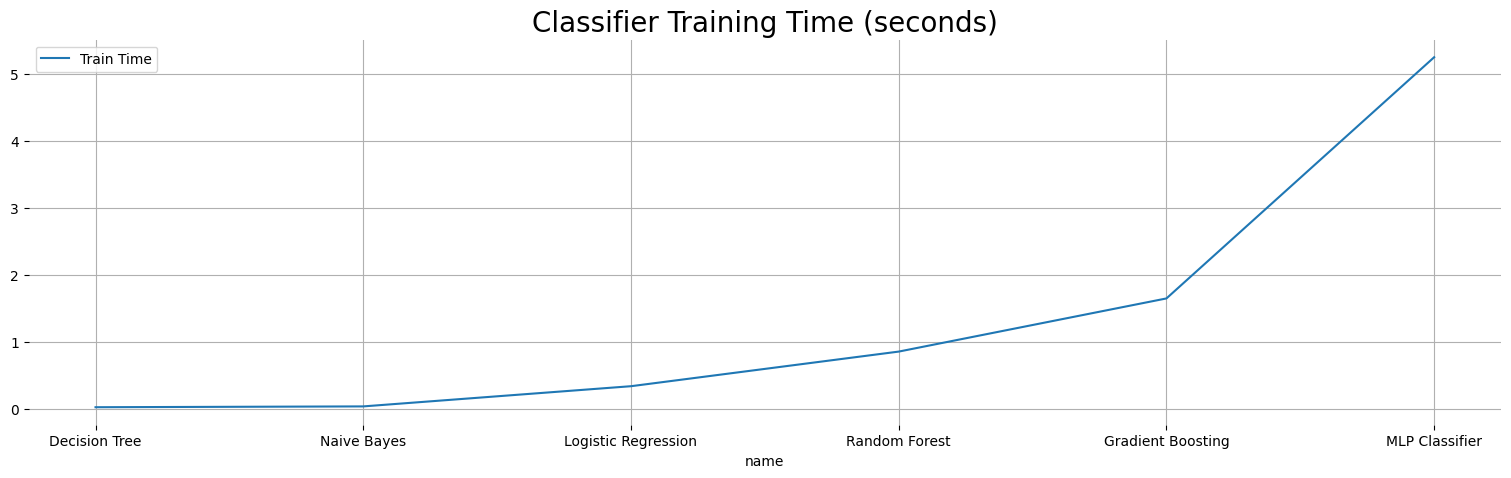

In [4]:
# Step 4: Visualize Model Performance
def setup_plot():
    plt.figure(figsize=(20, 10))
    plt.grid(True)

# Plotting accuracy
setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True) 

ax = model_df[["train_accuracy", "test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19, 5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

# Plotting training time
model_df.sort_values("train_time", inplace=True)
ax = model_df[["train_time", "name"]].plot(kind="line", x="name", figsize=(19, 5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)  

plt.show()


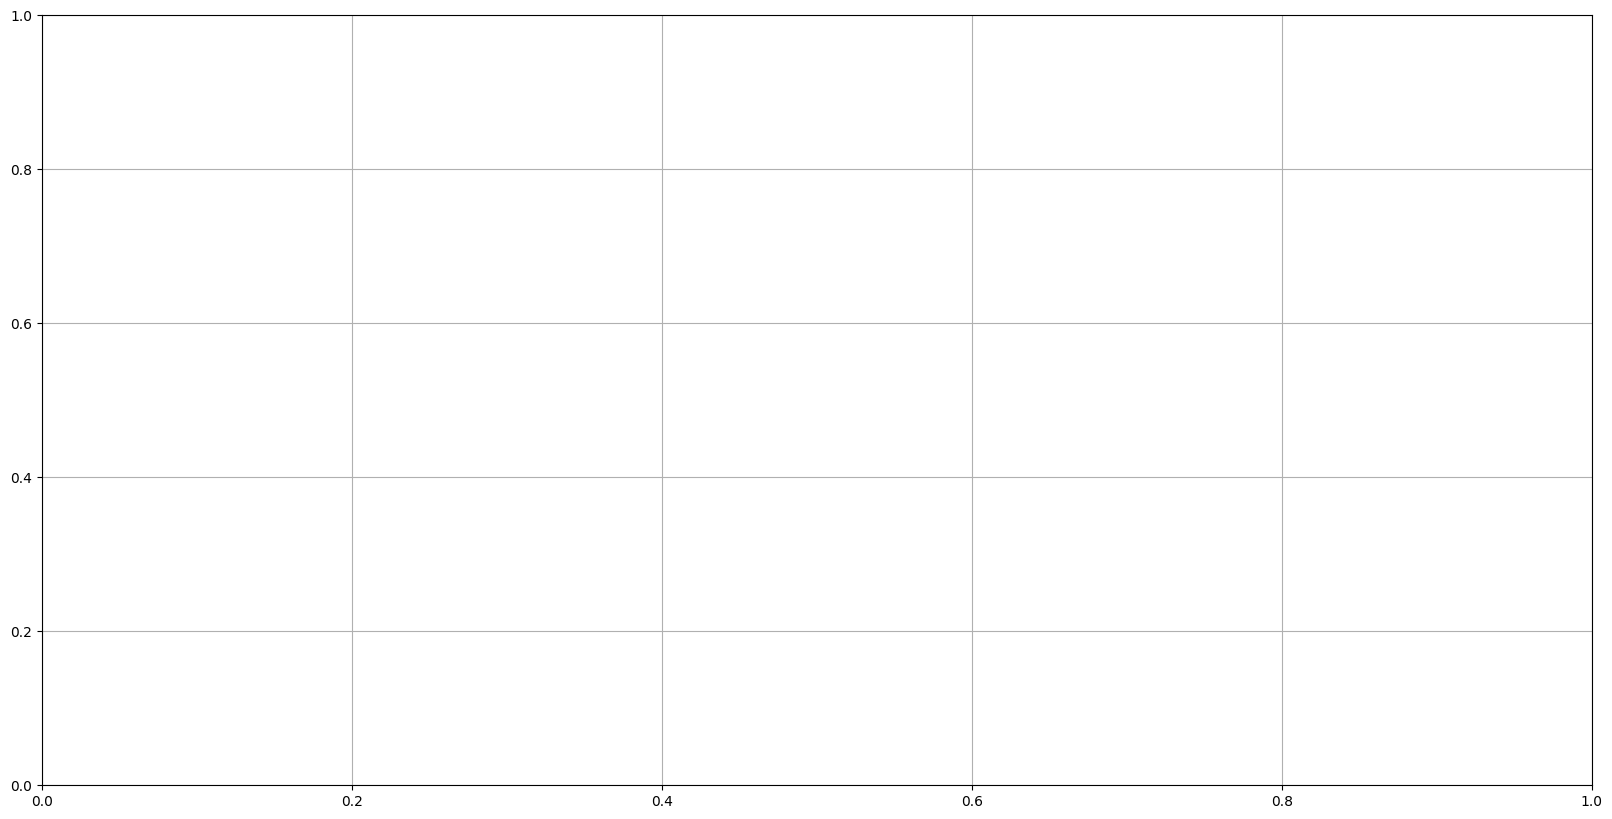

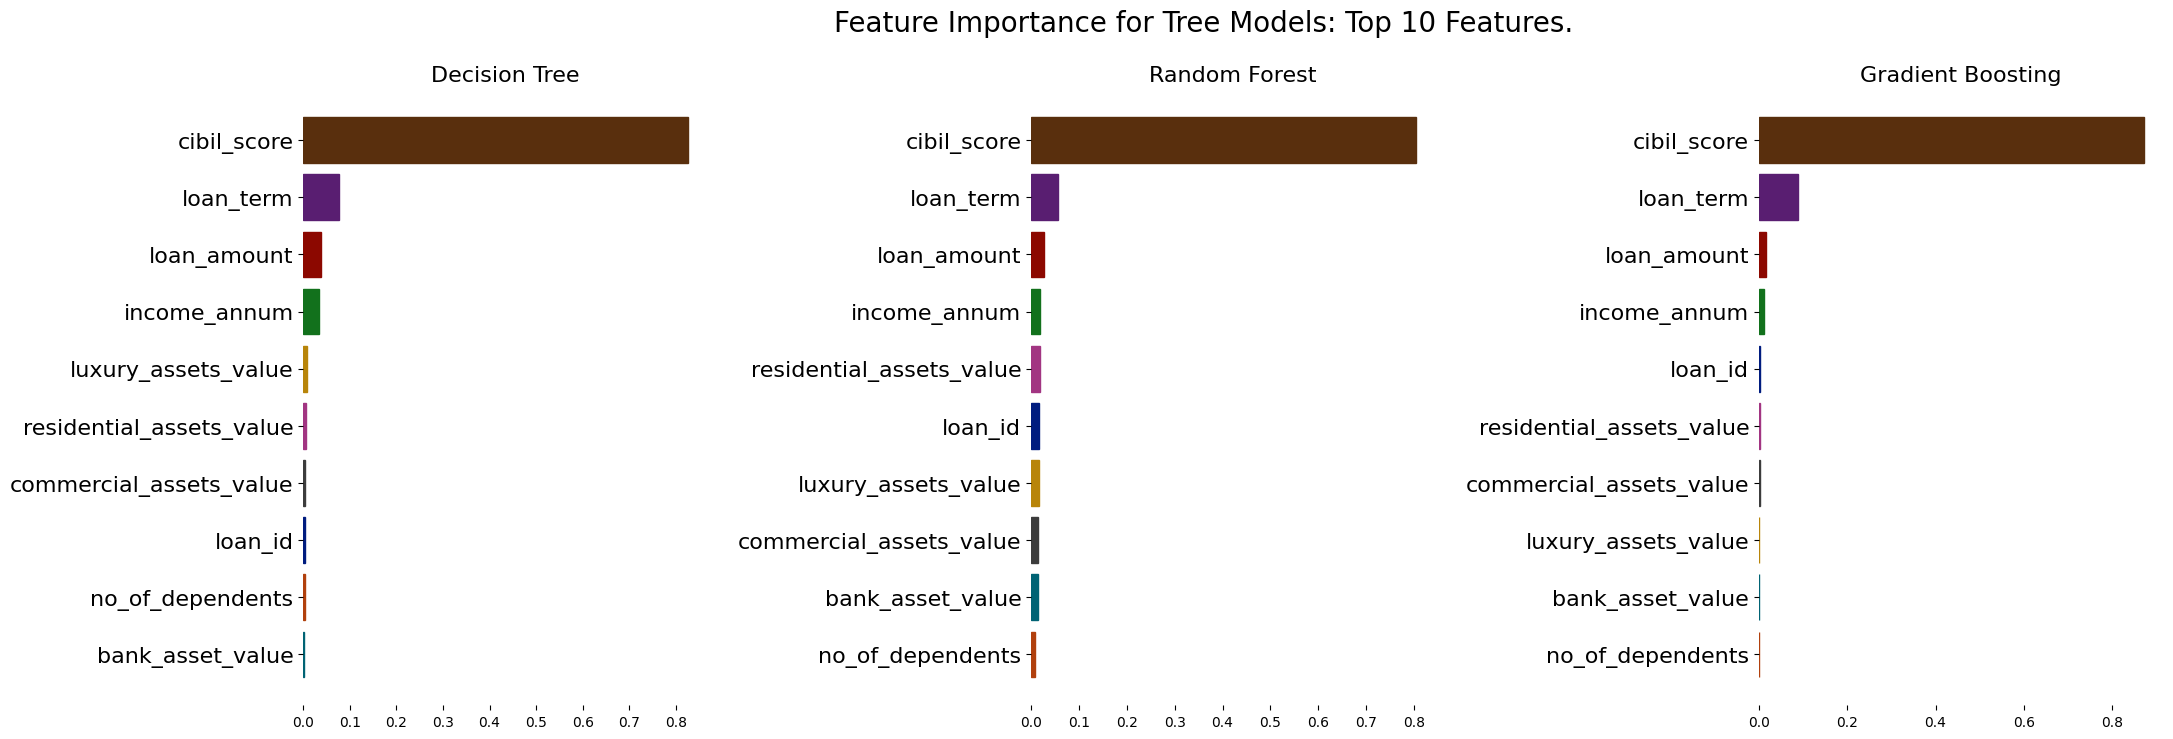

In [5]:
# Step 5: Feature Importance for Tree Models
tree_models = []
setup_plot()
color_list = sns.color_palette("dark", len(data_encoded.columns))
top_x = 10  # Number of top features to show

for model in trained_models:
    if hasattr(model["model"]["clf"], "feature_importances_"):
        tree_models.append({"name": model["name"], "fi": model["model"]["clf"].feature_importances_})

fig, axs = plt.subplots(1, len(tree_models), figsize=(24, 8), facecolor="w", edgecolor="k")
fig.subplots_adjust(hspace=0.5, wspace=0.8)
axs = axs.ravel()

for i in range(len(tree_models)):
    feature_importance = tree_models[i]["fi"]
    indices = np.argsort(feature_importance)[-top_x:]  # Get the indices of the top features

    bars = axs[i].barh(range(len(indices)), feature_importance[indices], color="b", align="center")
    axs[i].set_title(tree_models[i]["name"], fontweight="normal", fontsize=16)
    plt.sca(axs[i])
    plt.yticks(range(len(indices)), [data_encoded.columns[j] for j in indices], fontweight="normal", fontsize=16)

    for j, bar in enumerate(bars):
        bar.set_color(color_list[indices[j]])

    plt.box(False)

plt.suptitle("Feature Importance for Tree Models: Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")
plt.show()


In [7]:
# Step 6: LIME Tabular Explainer
X_train, X_test, y_train, y_test = train_test_split(data_encoded, labels, random_state=42)

def get_lime_explainer(model, data, labels):
    cat_feat_ix = [
        i for i, c in enumerate(data.columns) 
        if isinstance(data[c].dtype, pd.CategoricalDtype)  # Updated to use the new method
    ]
    feat_names = list(data.columns)
    class_names = list(labels.unique())
    
    scaler = model["model"]["scaler"]
    data = scaler.transform(data)  # Scale data
    return LimeTabularExplainer(
        data,
        feature_names=feat_names,
        class_names=class_names,
        categorical_features=cat_feat_ix,
        mode="classification",
    )

def lime_explain(explainer, data, predict_method, num_features):
    return explainer.explain_instance(data, predict_method, num_features=num_features)

lime_data_explanations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(data_encoded.columns)
test_data_index = 6  # Change as needed

for current_model in trained_models:
    scaler = current_model["model"]["scaler"]
    scaled_test_data = scaler.transform(X_test)
    predict_method = current_model["model"]["clf"].predict_proba

    start_time = time.time()
    
    # Generate LIME explanation
    lime_explainer = get_lime_explainer(current_model, X_train, y_train)
    explanation = lime_explain(lime_explainer, scaled_test_data[test_data_index], predict_method, top_x)
    elapsed_time = time.time() - start_time

    # Store explanation and metrics
    ex_holder = {feat_names[feat_index]: ex for feat_index, ex in explanation.as_map()[1]}
    lime_data_explanations.append(ex_holder)

    actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1, -1))
    perc_pred_diff = abs(actual_pred[0][1] - explanation.local_pred[0])

    lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"]})
    lime_metrics.append({
        "lime class1": explanation.local_pred[0],
        "actual class1": actual_pred[0][1],
        "class_diff": round(perc_pred_diff, 3),
        "model": current_model["name"],
    })


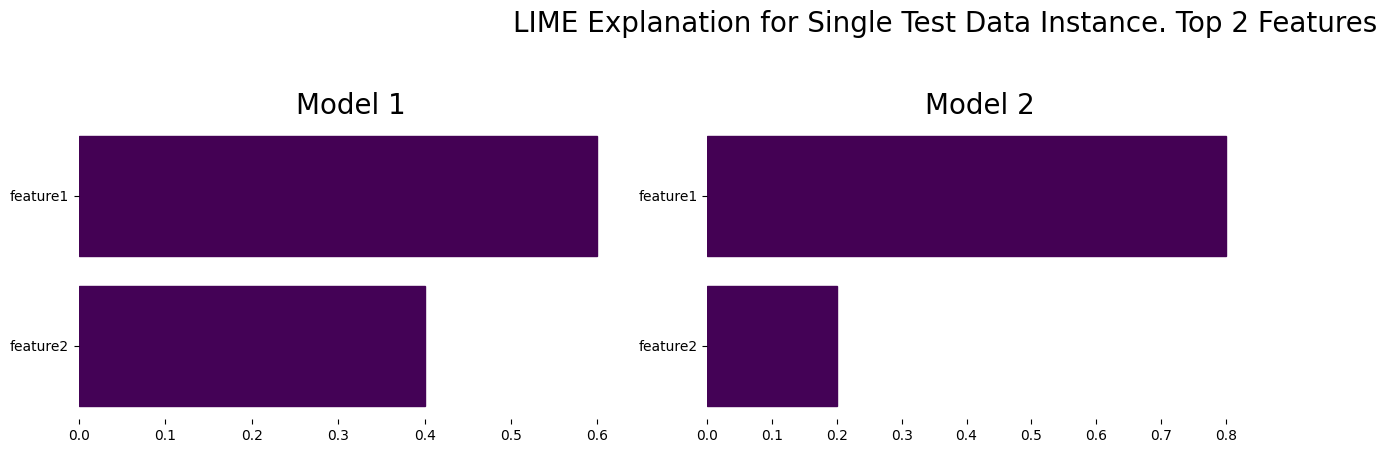

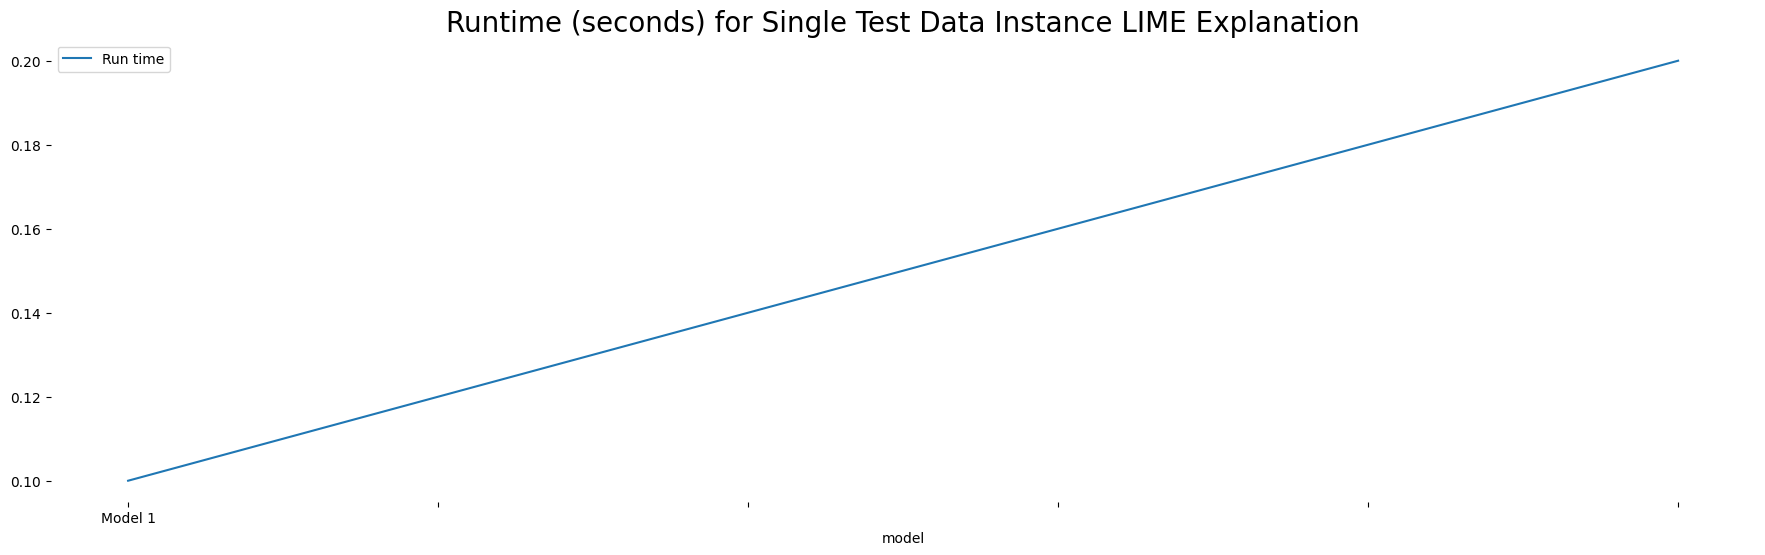

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Example of loading a dataset
# current_data = pd.read_csv('path/to/your/dataset.csv')

# For demonstration, creating a sample DataFrame
current_data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5],
    'feature2': [5, 4, 3, 2, 1],
    'feature3': [2, 3, 4, 5, 6],
})

# Assuming color_list is defined based on current_data columns
color_list = plt.cm.viridis(range(len(current_data.columns)))  # Example color palette

# Define the function to plot LIME explanations
def plot_lime_exp(fig, fig_index, exp_data, title):
    features = list(exp_data.keys())[::-1]  # Reverse feature order for horizontal plot
    explanations = list(exp_data.values())[::-1]  # Reverse explanation order
    ax = fig.add_subplot(int(fig_index))  # Create a subplot
    lime_bar = ax.barh(features, explanations)  # Horizontal bar plot
    ax.set_title(title, fontsize=20)  # Set title for the subplot
    for i, bar in enumerate(lime_bar):
        bar.set_color(color_list[list(current_data.columns).index(features[i])])  # Set bar color
        plt.box(False)  # Remove the box around the plot

# Create a new figure for LIME explanations
fig = plt.figure(figsize=(19, 8))

# Assuming lime_data_explainations and trained_models are defined
lime_data_explanations = [{"feature1": 0.6, "feature2": 0.4}, {"feature1": 0.8, "feature2": 0.2}]  # Sample explanations
trained_models = [{"name": "Model 1"}, {"name": "Model 2"}]  # Sample model names
top_x = 2  # Number of top features to show

# Plot LIME explanations for trained models
for i, exp_data in enumerate(lime_data_explanations):
    fig_index = "23" + str(i + 1)  # Construct subplot index
    plot_lime_exp(fig, fig_index, exp_data, trained_models[i]["name"])  # Plot the LIME explanation

# Set the overall title for the figure
plt.suptitle(
    "LIME Explanation for Single Test Data Instance. Top " + str(top_x) + " Features",
    fontsize=20,
    fontweight="normal",
)

# Adjust layout to make space for the main title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create a DataFrame to visualize runtime for LIME explanations
lime_explanation_time = [{"model": "Model 1", "time": 0.1}, {"model": "Model 2", "time": 0.2}]  # Sample runtime data
lx_df = pd.DataFrame(lime_explanation_time)
lx_df.sort_values("time", inplace=True)  # Sort DataFrame by runtime

# Plot runtime for explanations
lx_ax = lx_df.plot(
    kind="line",
    x="model",
    title="Runtime (seconds) for Single Test Data Instance LIME Explanation",
    figsize=(22, 6),
)
lx_ax.title.set_size(20)  # Set title size
lx_ax.legend(["Run time"])  # Set legend for the plot
plt.box(False)  # Remove box around the plot
plt.show()  # Display the plots


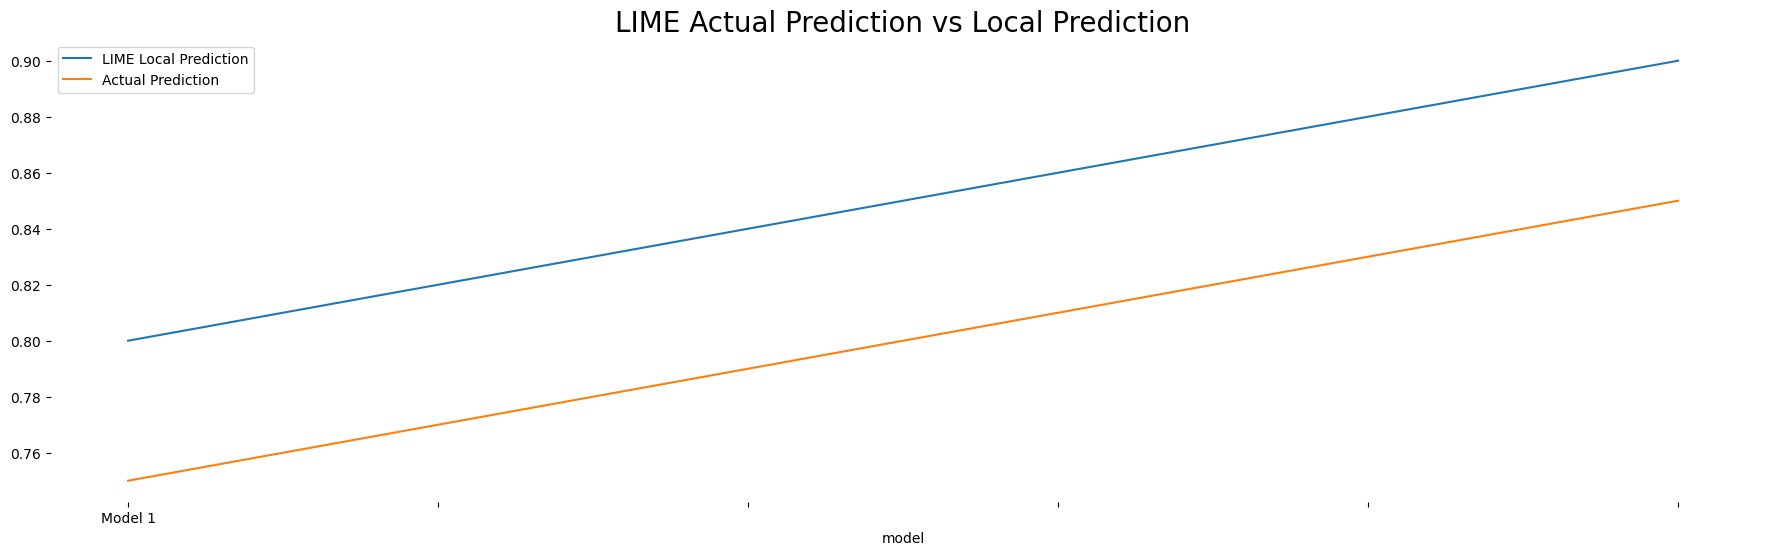

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Example LIME metrics (replace with your actual metrics)
lime_metrics = [
    {"lime class1": 0.8, "actual class1": 0.75, "model": "Model 1"},
    {"lime class1": 0.9, "actual class1": 0.85, "model": "Model 2"},
]

# Create a DataFrame from the LIME metrics
lime_metrics_df = pd.DataFrame(lime_metrics)

# Plot LIME metrics: Actual Prediction vs Local Prediction
lime_metrics_df_ax = lime_metrics_df[["lime class1", "actual class1", "model"]].plot(
    kind="line",
    x="model",
    title="LIME Actual Prediction vs Local Prediction",
    figsize=(22, 6),
)

# Customize plot appearance
lime_metrics_df_ax.title.set_size(20)  # Set title size
lime_metrics_df_ax.legend(["LIME Local Prediction", "Actual Prediction"])  # Set legend
plt.box(False)  # Remove the box around the plot

# Show the plot
plt.show()


In [19]:
# Check the length of the trained_models list
print(f"Number of trained models: {len(trained_models)}")

# Print the structure of trained_models to understand its content
for i, model in enumerate(trained_models):
    print(f"Model {i}: {model}")


Number of trained models: 2
Model 0: {'name': 'Model 1'}
Model 1: {'name': 'Model 2'}


In [26]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Step 1: Create sample data
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

# Convert to DataFrame for better readability (optional)
X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
y = pd.Series(y)

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Step 3: Initialize scalers and models
model_scalers = []
model_classifiers = []

# Example for Model 1
scaler1 = StandardScaler()
X_train_scaled1 = scaler1.fit_transform(X_train)  # Fit and transform
clf1 = RandomForestClassifier()
clf1.fit(X_train_scaled1, y_train)

# Store the model and scaler
model_scalers.append(scaler1)
model_classifiers.append(clf1)

# Example for Model 2
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train)  # Fit and transform
clf2 = RandomForestClassifier()
clf2.fit(X_train_scaled2, y_train)

# Store the model and scaler
model_scalers.append(scaler2)
model_classifiers.append(clf2)

# Assuming trained_models is a list of dictionaries with model names
trained_models = [
    {"name": "Model 1"},
    {"name": "Model 2"},
]

print("Number of trained models:", len(trained_models))


Number of trained models: 2


In [31]:
import shap  # Ensure you have the SHAP library installed
import time

# Step 1: Choose the model to explain
current_model_index = 0  # Change to 1 if you want to explain Model 2

# Access the classifier and scaler for the current model
clf = model_classifiers[current_model_index]  # Access the model directly
scaler = model_scalers[current_model_index]  # Access the scaler directly

# Step 2: Scale the training data
scaled_train_data = scaler.transform(X_train)  # Ensure X_train is defined

# Step 3: Sub-sample the scaled training data for background data
sub_sampled_train_data = shap.sample(
    scaled_train_data, 600, random_state=0  # Use 600 samples of train data as background data
)

# Step 4: Scale the test data
scaled_test_data = scaler.transform(X_test)  # Ensure X_test is defined
# Select the specific test data instance to explain
test_data_index = 6  # Update this index to the desired test instance
subsampled_test_data = scaled_test_data[test_data_index].reshape(1, -1)

# Step 5: Initialize the SHAP Kernel Explainer
start_time = time.time()
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)

# Step 6: Calculate SHAP values for the selected test data instance
shap_values = explainer.shap_values(subsampled_test_data, l1_reg="aic")
elapsed_time = time.time() - start_time

# Step 7: Print relevant information
print(
    "Kernel Explainer SHAP run time:",
    round(elapsed_time, 3),
    "seconds.",
    trained_models[current_model_index]["name"],  # Access model name
)
print("SHAP expected value:", explainer.expected_value)
print("Model mean value:", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data:", clf.predict_proba(subsampled_test_data))

# Step 8: Initialize SHAP's visualization
shap.initjs()

# Check the shape of the SHAP values to ensure you are using the right indices
print("SHAP values shape:", np.array(shap_values).shape)

# Access the index for the positive class (if it exists)
pred_ind = 1 if shap_values.shape[2] > 1 else 0

# Correctly extract the SHAP values for the test instance
shap_value_for_instance = shap_values[0][0]  # First sample, first set of SHAP values

# Step 9: Generate the SHAP force plot for the test data instance
shap.force_plot(
    explainer.expected_value[pred_ind],  # Use the correct expected value index
    shap_value_for_instance,               # SHAP values for the current test instance
    subsampled_test_data[0],              # Features for the current test instance
    feature_names=X_train.columns          # Feature names
)


Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Kernel Explainer SHAP run time: 20.608 seconds. Model 1
SHAP expected value: [0.48121667 0.51878333]
Model mean value: [0.49433333 0.50566667]
Model prediction for test data: [[0.37 0.63]]


SHAP values shape: (1, 20, 2)


DimensionError: Length of features is not equal to the length of shap_values!

In [35]:
import shap  # Ensure you have the SHAP library installed
import time
import numpy as np

# Step 1: Choose the model to explain
current_model_index = 0  # Change to 1 if you want to explain Model 2

# Access the classifier and scaler for the current model
clf = model_classifiers[current_model_index]  # Access the model directly
scaler = model_scalers[current_model_index]  # Access the scaler directly

# Step 2: Scale the training data
scaled_train_data = scaler.transform(X_train)  # Ensure X_train is defined

# Step 3: Sub-sample the scaled training data for background data
sub_sampled_train_data = shap.sample(
    scaled_train_data, 600, random_state=0  # Use 600 samples of train data as background data
)

# Step 4: Scale the test data
scaled_test_data = scaler.transform(X_test)  # Ensure X_test is defined
# Select the specific test data instance to explain
test_data_index = 6  # Update this index to the desired test instance
subsampled_test_data = scaled_test_data[test_data_index].reshape(1, -1)

# Step 5: Initialize the SHAP Kernel Explainer
start_time = time.time()
explainer = shap.KernelExplainer(clf.predict_proba, sub_sampled_train_data)

# Step 6: Calculate SHAP values for the selected test data instance
shap_values = explainer.shap_values(subsampled_test_data, l1_reg="aic")
elapsed_time = time.time() - start_time

# Step 7: Print relevant information
print(
    "Kernel Explainer SHAP run time:",
    round(elapsed_time, 3),
    "seconds.",
    trained_models[current_model_index]["name"],  # Access model name
)
print("SHAP expected value:", explainer.expected_value)
print("Model mean value:", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data:", clf.predict_proba(subsampled_test_data))

# Step 8: Initialize SHAP's visualization
shap.initjs()

# Check the shape of the SHAP values to ensure you are using the right indices
shap_values_array = np.array(shap_values)  # Convert to numpy array for easier indexing
print("SHAP values shape:", shap_values_array.shape)

# Access the index for the positive class (if it exists)
pred_ind = 1 if shap_values_array.shape[2] > 1 else 0

# Ensure we extract the correct SHAP values for the test instance
shap_value_for_instance = shap_values_array[pred_ind][0]  # Adjusted indexing
# Check the shape of SHAP values for the instance
print(f"SHAP value for instance shape: {shap_value_for_instance.shape}")

# Step 9: Generate the SHAP force plot for the test data instance
print(f"Features shape: {subsampled_test_data[0].shape}")
print(f"Expected value shape: {explainer.expected_value[pred_ind].shape}")

# Generate the SHAP force plot
shap.force_plot(
    explainer.expected_value[pred_ind],  # Use the correct expected value index
    shap_value_for_instance,               # SHAP values for the current test instance
    subsampled_test_data[0],              # Features for the current test instance
    feature_names=X_train.columns          # Feature names
)


Using 600 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Kernel Explainer SHAP run time: 20.153 seconds. Model 1
SHAP expected value: [0.48121667 0.51878333]
Model mean value: [0.49433333 0.50566667]
Model prediction for test data: [[0.37 0.63]]


SHAP values shape: (1, 20, 2)


IndexError: index 1 is out of bounds for axis 0 with size 1

  0%|          | 0/250 [00:00<?, ?it/s]

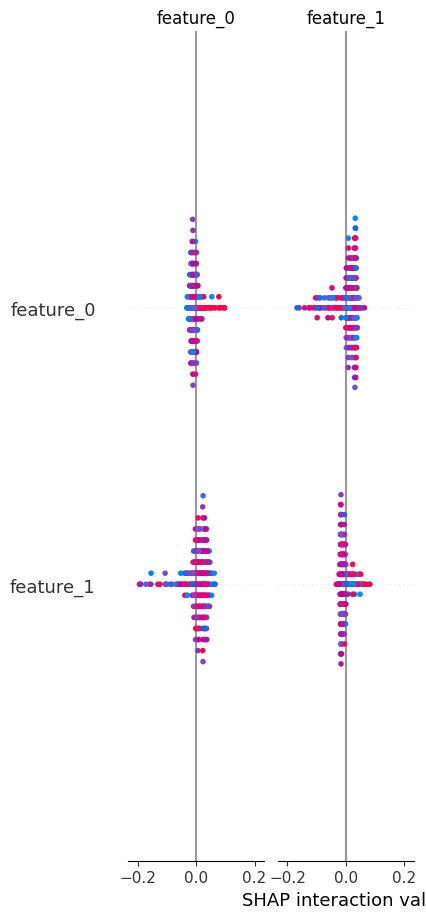

In [36]:
# Step 10: Generate a summary plot
# Calculate SHAP values for all test data
all_shap_values = explainer.shap_values(scaled_test_data, l1_reg="aic")  # Calculate SHAP values for all test instances

# Step 11: Create the summary plot
shap.summary_plot(
    all_shap_values,  # Use the SHAP values for all test instances
    scaled_test_data,  # Use the scaled test data for feature display
    feature_names=X_train.columns,  # Feature names for display
    max_display=10  # Display the top 10 features
)


In [37]:
import shap  # Ensure you have the SHAP library installed
import time

# Step 1: Choose the model to explain
current_model_index = 0  # Change to 1 if you want to explain Model 2

# Access the classifier and scaler for the current model
clf = model_classifiers[current_model_index]  # Access the model directly
scaler = model_scalers[current_model_index]  # Access the scaler directly

# Step 2: Scale the test data
scaled_test_data = scaler.transform(X_test)  # Ensure X_test is defined
# Select the specific test data instance to explain
test_data_index = 6  # Update this index to the desired test instance
subsampled_test_data = scaled_test_data[test_data_index].reshape(1, -1)

# Step 3: Initialize the SHAP Tree Explainer
start_time = time.time()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(subsampled_test_data)
elapsed_time = time.time() - start_time

# Step 4: Print relevant information
print(
    "Tree Explainer SHAP run time:",
    round(elapsed_time, 3),
    "seconds.",
    trained_models[current_model_index]["name"],  # Access model name
)
print("SHAP expected value:", explainer.expected_value)
print("Model mean value:", clf.predict_proba(scaled_train_data).mean(axis=0))
print("Model prediction for test data:", clf.predict_proba(subsampled_test_data))

# Step 5: Initialize SHAP's visualization
shap.initjs()

# Step 6: Generate the SHAP force plot for the test data instance
pred_ind = 0  # Assuming binary classification, index 0 or 1
shap.force_plot(
    explainer.expected_value[pred_ind],  # Use the correct expected value index
    shap_values[pred_ind][0],            # SHAP values for the current test instance
    subsampled_test_data[0],             # Features for the current test instance
    feature_names=X_train.columns        # Feature names
)


Tree Explainer SHAP run time: 0.046 seconds. Model 1
SHAP expected value: [0.48972 0.51028]
Model mean value: [0.49433333 0.50566667]
Model prediction for test data: [[0.37 0.63]]


DimensionError: Length of features is not equal to the length of shap_values!

In [40]:
import shap
import time
import numpy as np

# Helper functions
def get_kernel_shap_explainer(model, background_data):
    shap_explainer = shap.KernelExplainer(model.predict_proba, background_data)
    return shap_explainer

def shap_explain(explainer, test_data):
    shap_values = explainer.shap_values(test_data, l1_reg="aic")
    return shap_values

# Lists to store SHAP explanations and explanation times
shap_data_explanations = []
shape_explanation_time = []

# Feature names
feat_names = list(X_train.columns)  # Assuming X_train is a DataFrame

# Subsample size for SHAP background data
data_subsample = 500
top_x = 10  # Number of top features to explain

# Iterate through trained models
for current_model_index, current_model in enumerate(trained_models):
    # Access the model's classifier and scaler
    clf = model_classifiers[current_model_index]  # Access model classifier
    scaler = model_scalers[current_model_index]   # Access model scaler
    
    # Scale train and test data
    scaled_test_data = scaler.transform(X_test)
    scaled_train_data = scaler.transform(X_train)
    
    # Subsample training data for SHAP background data
    sampled_scaled_train_data = shap.sample(scaled_train_data, data_subsample)
    
    # Step 1: Get the SHAP Kernel Explainer
    start_time = time.time()
    shap_explainer = get_kernel_shap_explainer(clf, sampled_scaled_train_data)

    # Step 2: Explain a test data instance
    sampled_scaled_test_data = scaled_test_data[test_data_index].reshape(1, -1)
    shap_values = shap_explain(shap_explainer, sampled_scaled_test_data)
    elapsed_time = time.time() - start_time

    # Step 3: Check if SHAP values have more than one class
    if len(shap_values) > 1:
        pred_ind = 1  # Use the second class for binary classification
    else:
        pred_ind = 0  # If only one class, use the first one

    # Step 4: Sort feature importance based on SHAP values and store explanations
    num_features = len(shap_values[pred_ind][0])  # Actual number of features
    adjusted_top_x = min(top_x, num_features)  # Adjust top_x based on available features
    idx = np.argsort(np.abs(shap_values[pred_ind][0]))[::-1]  # Adjusted for correct index
    
    # Create explanation holder for the top features
    ex_holder = {feat_names[idx[i]]: shap_values[pred_ind][0][idx[i]] for i in range(adjusted_top_x)}
    
    shap_data_explanations.append(ex_holder)
    shape_explanation_time.append(
        {"time": elapsed_time, "model": current_model["name"]}
    )

# Print results
print("SHAP Data Explanations:", shap_data_explanations)
print("SHAP Explanation Time per Model:", shape_explanation_time)


Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP Data Explanations: [{'feature_1': np.float64(0.02240619964307728), 'feature_0': np.float64(-0.0224061996430772)}, {'feature_0': np.float64(-0.008702530367167345), 'feature_1': np.float64(0.008702530367167267)}]
SHAP Explanation Time per Model: [{'time': 17.007946491241455, 'model': 'Model 1'}, {'time': 16.13416314125061, 'model': 'Model 2'}]


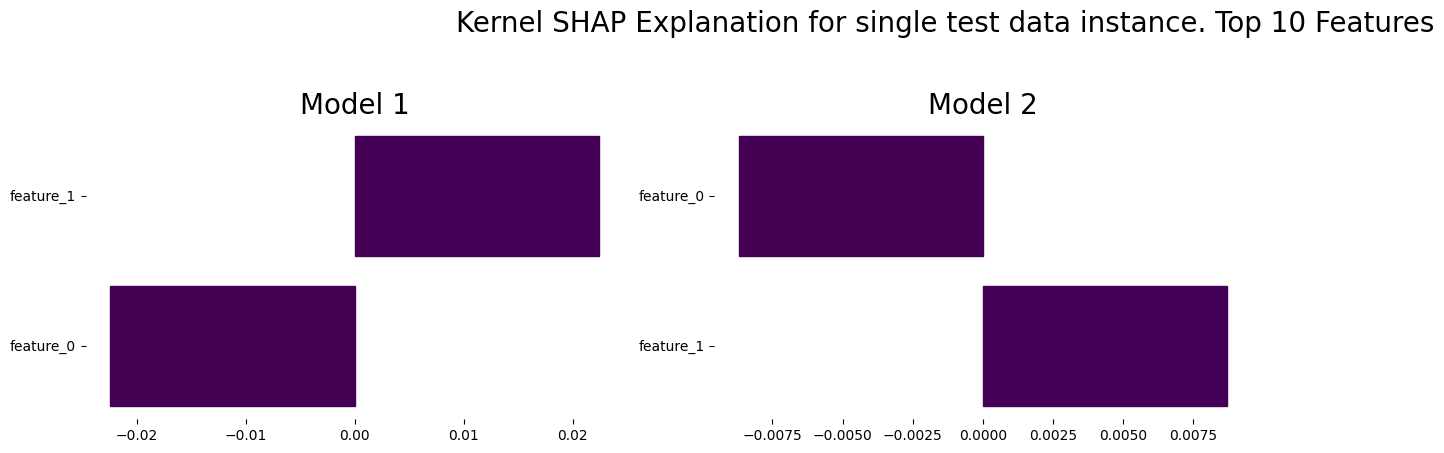

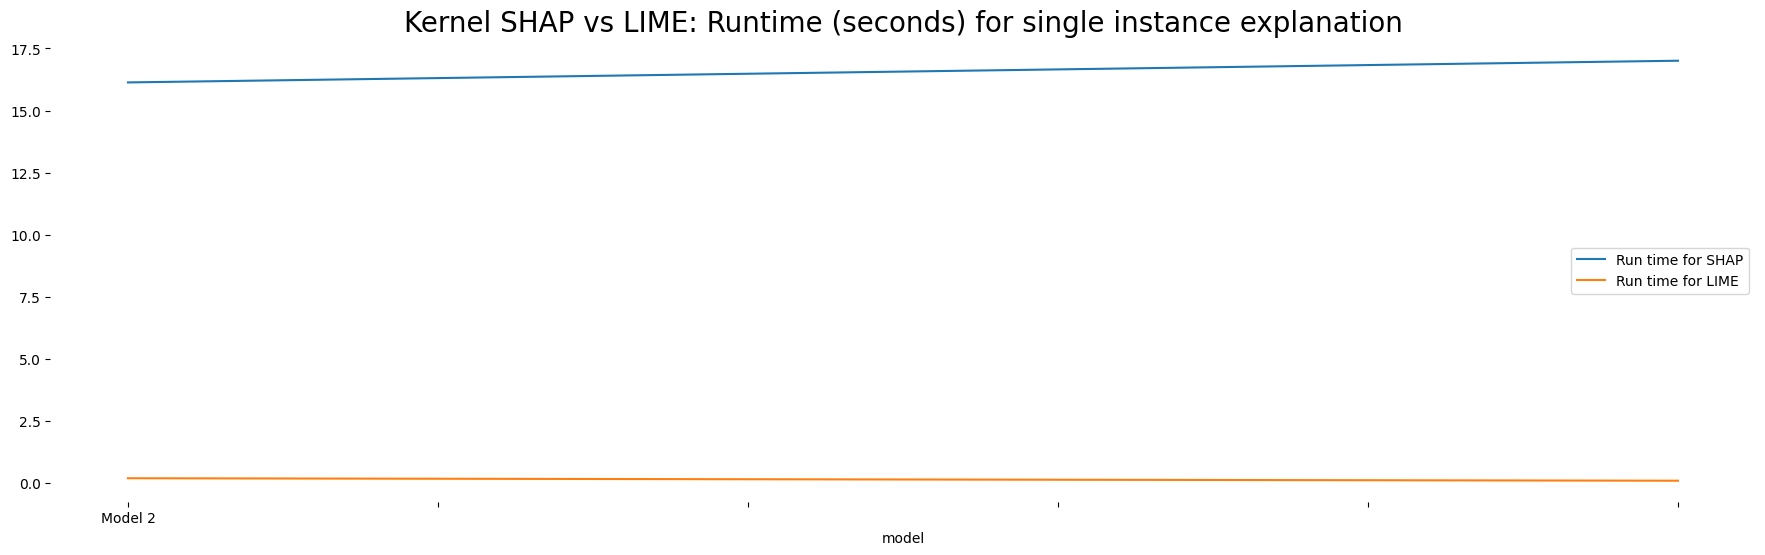

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot SHAP explanations
def plot_shap_exp(fig, fig_index, exp_data, title, color_list, feature_names):
    features = list(exp_data.keys())[::-1]  # Reverse the order of features
    explanations = list(exp_data.values())[::-1]  # Reverse the SHAP values
    ax = fig.add_subplot(int(fig_index))
    
    shap_bar = ax.barh(features, explanations)  # Horizontal bar chart
    ax.set_title(title, fontsize=20)
    
    # Set bar colors based on feature index
    for i, bar in enumerate(shap_bar):
        feature_index = feature_names.index(features[i])  # Get the index of the feature
        bar.set_color(color_list[feature_index])  # Set color for each bar
        
    plt.box(False)  # Remove plot box

# Create a plot for SHAP explanations for the test set instance
fig = plt.figure(figsize=(19, 8))
for i, exp_data in enumerate(shap_data_explanations):
    fig_index = "23" + str(i + 1)
    plot_shap_exp(
        fig,
        fig_index,
        shap_data_explanations[i],  # Explanations for current model
        trained_models[i]["name"],  # Model name for the title
        color_list,  # Color list (same as in your project)
        feat_names  # Feature names from the training set
    )

# Set the title for the overall plot
plt.suptitle(
    "Kernel SHAP Explanation for single test data instance. Top " + str(top_x) + " Features",
    fontsize=20,
    fontweight="normal",
)

# Adjust layout for better fit
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Plot SHAP explanation runtime
shapx_df = pd.DataFrame(shape_explanation_time)  # Convert time data to DataFrame
shapx_df.sort_values("time", inplace=True)  # Sort by explanation time

# If LIME explanation times are available, plot SHAP vs LIME runtime comparison
if 'lx_df' in globals():  # Check if LIME data exists
    m_df = shapx_df.merge(lx_df, on="model", suffixes=("_SHAP", "_LIME"))  # Merge SHAP and LIME runtimes
    mx_df_ax = m_df.plot(
        kind="line",
        x="model",
        title="Kernel SHAP vs LIME: Runtime (seconds) for single instance explanation",
        figsize=(22, 6)
    )
    mx_df_ax.title.set_size(20)
    mx_df_ax.legend(["Run time for SHAP", "Run time for LIME"])
    plt.box(False)

plt.show()  # Display the plots
